In [28]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import numpy as np
import matplotlib.pyplot as plt

# To plot using LaTeX, sometimes it gives trouble, in that case comment these two lines
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

import nibabel as nib
import gdown
from generate_datasets import norm, resize_img, resize_mask, draw_grid, elastic_transform

%config InlineBackend.print_figure_kwargs = {'facecolor':'white'}

In [29]:
# Set CPU as the only available physical device, as my GPU memory is not enough sometimes
# tf.config.set_visible_devices([], 'GPU')

In [30]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Dataset

The images are provided by [COVID-19 CT segmentation dataset
](http://medicalsegmentation.com/covid19/), it is a dataset of 100 axial CT images from more than 40 patients with COVID-19. The images were segmented by a radiologist using 3 labels: 

- Ground-glass (mask value = 1)
- Consolidation (mask value = 2)
- Pleural effusion (mask value = 3)

In [23]:
!mkdir Images

In [40]:
# Training images
gdown.download('https://drive.google.com/uc?id=1SJoMelgRqb0EuqlTuq6dxBWf2j9Kno8S',
               output='Images/tr_im.nii.gz', quiet=True)

# Training masks
gdown.download('https://drive.google.com/uc?id=1MEqpbpwXjrLrH42DqDygWeSkDq0bi92f',
               output='Images/tr_mask.nii.gz', quiet=True)

# Validation dataset
gdown.download('https://drive.google.com/uc?id=1Tl5PTS2rmajWKJMrYcZ2Na5DURvbbpit',
               output='Images/val_im.nii.gz', quiet=True)

'Images/val_im.nii.gz'

In [42]:
!gunzip Images/tr_im.nii.gz
!gunzip Images/tr_mask.nii.gz
!gunzip Images/val_im.nii.gz

In [43]:
imgs = nib.load('Images/tr_im.nii')
masks = nib.load('Images/tr_mask.nii')
validation = nib.load('Images/val_im.nii')
x_o = imgs.get_fdata()
y_o = masks.get_fdata()

x_o = np.array([norm(resize_img(x_o[:,:,i], 512)) for i in range(imgs.shape[2])])
y_o = np.array([resize_mask(y_o[:,:,i], 512) for i in range(imgs.shape[2])])

x_o.shape, y_o.shape

((100, 512, 512), (100, 512, 512))

## Generate models

In [5]:
def generate_unet(img_size):
    output_channels = 4      # number of classes on the dataset
    base_model = tf.keras.applications.MobileNetV2(input_shape=[img_size, img_size, 3], 
                                                   include_top=False)
    layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
    ]
    layers = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

    down_stack.trainable = False

    up_stack = [
        pix2pix.upsample(512, 3),  # 4x4 -> 8x8
        pix2pix.upsample(256, 3),  # 8x8 -> 16x16
        pix2pix.upsample(128, 3),  # 16x16 -> 32x32
        pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    ]
    inputs = tf.keras.layers.Input(shape=[img_size, img_size, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
         output_channels, 3, strides=2,
         padding='same')  # 64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [6]:
def generate_unet_512(img_size=512):
    
    output_channels = 4      # number of classes on the dataset
    base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], 
                                                   include_top=False)
    layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
    ]
    layers = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

    down_stack.trainable = False

    up_stack = [
        pix2pix.upsample(512, 3),  # 4x4 -> 8x8
        pix2pix.upsample(256, 3),  # 8x8 -> 16x16
        pix2pix.upsample(128, 3),  # 16x16 -> 32x32
        pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    ]
    inputs = tf.keras.layers.Input(shape=[img_size, img_size, 3])
    mid = tf.keras.layers.MaxPooling2D(3, (4,4))(inputs)
    x = tf.keras.layers.Conv2D(3, (3,3), padding = 'same')(mid)

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
         output_channels, 3, strides=2,
         padding='same')(x)  #64x64 -> 128x128
    mid = tf.keras.layers.UpSampling2D((4,4))(last)
    mid_x = tf.keras.layers.Conv2D(4, (12,12), padding= 'same')(mid)
    x = tf.keras.layers.Conv2D(4, (3,3), padding= 'same')(mid_x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

## Generating datasets and training the model

In [7]:
from generate_datasets import generate_dataset
from make_predictions import color_mask, create_mask, show_predictions
from IPython.display import clear_output
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import model_from_json

In [ ]:
!mkdir Gif

In [9]:
def show_predictions(model, size, epoch, logs):
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(14,7))
    ax0.imshow(x_val[1]) 
    ax0.axis('off')
    ax0.set_title('Original image', size=16)
    
    ax1.imshow(color_mask(y_val[1].reshape(size,size), size=size))
    ax1.axis('off')
    ax1.set_title('Mask', size=16)
    
    pred_mask = model.predict(x_val[0:10])
    ax2.imshow(color_mask(create_mask(pred_mask, 1).numpy().reshape(size,size), size=size))
    ax2.axis('off')
    ax2.set_title('Prediction', size=16)
    
    mask_labels = np.ones((512, 32, 4))
    mask_labels[140:172] = np.array([0, 0, 0, 1])
    mask_labels[204:236] = np.array([55, 126, 184, 255])/255
    mask_labels[268:300] = np.array([77, 175, 74, 255])/255
    mask_labels[332:364] = np.array([152, 78, 163, 255])/255
    
    box = ax3.get_position()   
    box.x0 = box.x0 - 0.07
    box.x1 = box.x1 - 0.07
    ax3.set_position(box)
    ax3.imshow(mask_labels)
    ax3.tick_params(axis='x', which='both', bottom=False, top=False,labelbottom=False)
    ax3.tick_params(axis='y', which='both', left=False, labelleft=False, right = True, 
                   labelright=True)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['bottom'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax3.set_yticks([156, 220, 284, 348])
    ax3.set_yticklabels(['Background','Ground glass','Consolidation','Pleural effusion'],
                        size=14)
    
    acc, val_acc = logs['accuracy'], logs['val_accuracy']   
    plt.suptitle('Epoch {}'.format(epoch+1), size=18, y=0.8)
    fig.savefig('Gif/{}/{}.jpg'.format(size, epoch), bbox_inches='tight')
    
    plt.show()


class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        clear_output(wait=True)
        show_predictions(self.model, size, epoch, logs)

### 512 $\times$ 512 model

In [10]:
model_512 = generate_unet_512()
model_512.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [11]:
# Hyperparameters
samples = 4000
size = 512

TRAIN_LENGTH = samples
BATCH_SIZE = 100
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
EPOCHS = 40

In [12]:
checkpoint_512 = ModelCheckpoint("Models/best_weights_512.h5", 
                                 monitor='val_loss', 
                                 verbose=1,
                                 save_best_only=True, 
                                 mode='min')

The 512$\times$512 dataset is quite heavy (for my computer), so it is better to divide it in *'batches'*.

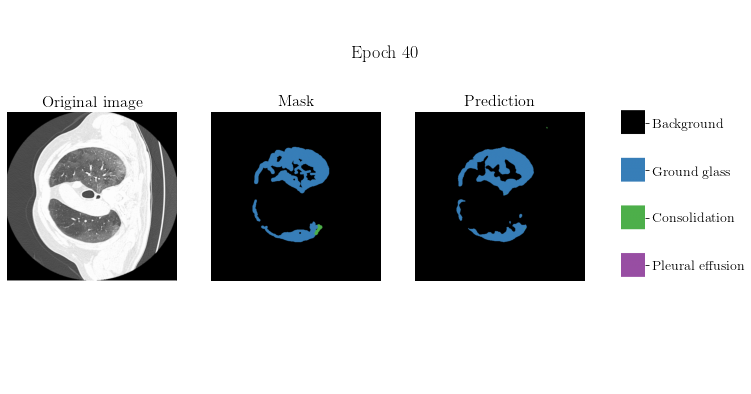

40/40 [==============================] - 5s 133ms/step - loss: 0.0284 - accuracy: 0.9754 - val_loss: 0.0694 - val_accuracy: 0.9780


In [26]:
batches = 10
imgs_per_batch = int(imgs.shape[2]/batches)
samples_per_batch = int(samples/batches)
losses = []
val_losses = []

for i in range(batches):
    print("Generating augmented 512x512 dataset of size {}".format(samples_per_batch))
    x_val, y_val, x, y = generate_dataset(
                       imgs.slicer[:,:,imgs_per_batch*i:imgs_per_batch*(i+1)], 
                       masks.slicer[:,:,imgs_per_batch*i:imgs_per_batch*(i+1)], 
                       size, samples_per_batch)
    
    print("Training 512x512 (step {})".format(i+1))
    trained_512 = model_512.fit(x, y, validation_data=(x_val, y_val),
                            epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH,
                            callbacks = [checkpoint_512, DisplayCallback()])
    
    losses.append(trained_512.history['loss'])
    val_losses.append(trained_512.history['val_loss'])

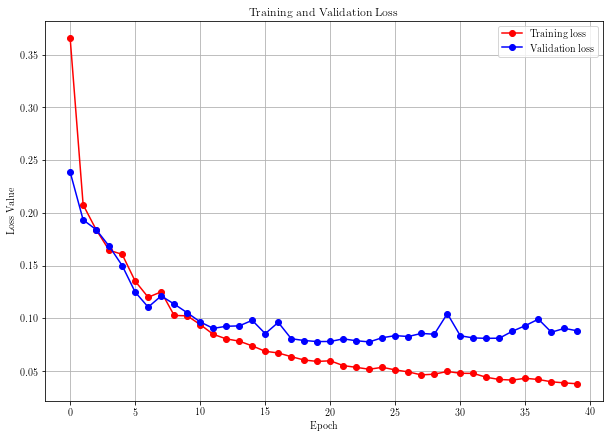

In [31]:
loss = losses[0]
val_loss = val_losses[0]

epochs = range(40)

plt.figure(figsize=(10,7))
plt.plot(epochs, loss, c='red', marker='o', label='Training loss')
plt.plot(epochs, val_loss, c='b', marker='o', label='Validation loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid()

plt.show()

Save the model.

In [15]:
# serialize model to JSON
model_json = model_512.to_json()
with open('Models/model_512.json', 'w') as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_512.save_weights('Models/model_512.h5')
print('Saved model to disk')

# json_file = open('model_224.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# modelo_224_4k = model_from_json(loaded_model_json)
# # load weights into new model
# modelo_224_4k.load_weights("model_224.h5")
# print("Loaded model from disk")

Saved model to disk


### 224 $\times$ 224 model

In [21]:
model_192 = generate_unet(192)
model_192.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [22]:
# Hyperparameters
samples = 4000
size = 224

TRAIN_LENGTH = samples
BATCH_SIZE = 100
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
EPOCHS = 40

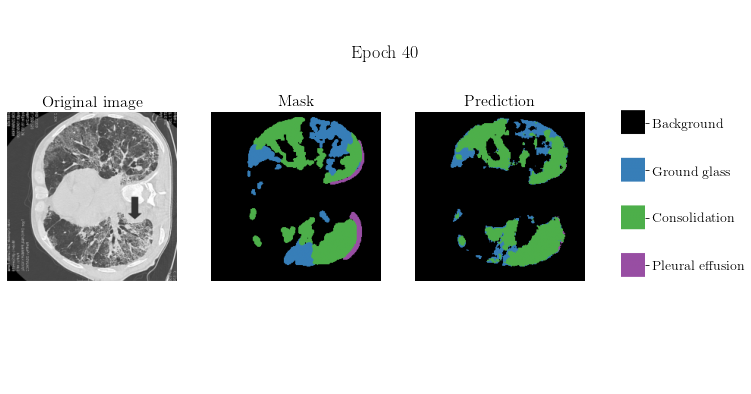

40/40 [==============================] - 13s 328ms/step - loss: 0.0335 - accuracy: 0.9515 - val_loss: 0.1032 - val_accuracy: 0.9676


In [23]:
checkpoint_224 = ModelCheckpoint("Models/best_weights_224.h5", 
                                 monitor='val_loss', 
                                 verbose=1,
                                 save_best_only=True, 
                                 mode='min')

print("Generating augmented 224x224 dataset of size {}".format(samples))
x_val, y_val, x, y = generate_dataset(imgs, masks, size, samples)

print("Training 224x224")
trained_224 = model_224.fit(x, y, validation_data=(x_val, y_val),
                            epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH,
                            callbacks = [checkpoint_224, DisplayCallback()])

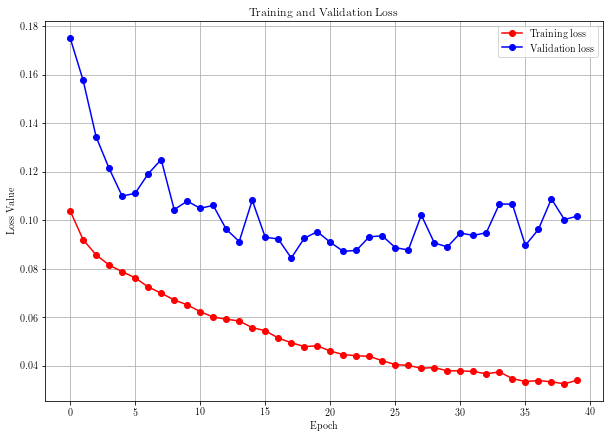

In [63]:
loss = trained_224.history['loss']
val_loss = trained_224.history['val_loss']

epochs = range(EPOCHS)

plt.figure(figsize=(10,7))
plt.plot(epochs, loss, c='red', marker='o', label='Training loss')
plt.plot(epochs, val_loss, c='b', marker='o', label='Validation loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid()

plt.show()

Save the model.

In [65]:
# serialize model to JSON
model_json = model_224.to_json()
with open('Models/model_224.json', 'w') as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_224.save_weights('Models/model_224.h5')
print('Saved model to disk')

# json_file = open('model_224.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# modelo_224_4k = model_from_json(loaded_model_json)
# # load weights into new model
# modelo_224_4k.load_weights("model_224.h5")
# print("Loaded model from disk")

Saved model to disk


### 192 $\times$ 192 model

In [13]:
model_192 = generate_unet(192)
model_192.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [14]:
# Hyperparameters
samples = 4000
size = 192

TRAIN_LENGTH = samples
BATCH_SIZE = 100
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
EPOCHS = 40

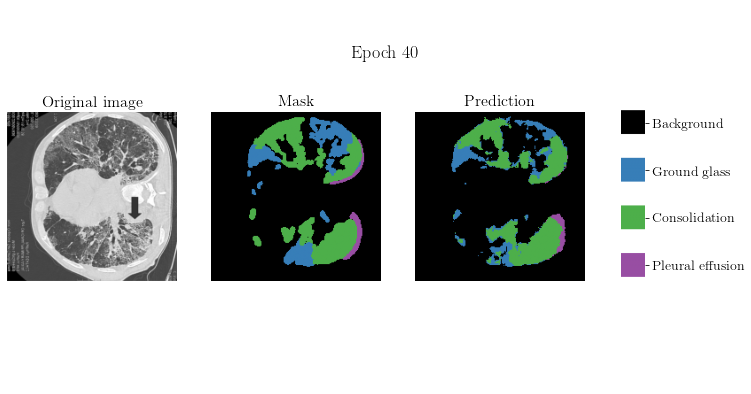

40/40 [==============================] - 11s 267ms/step - loss: 0.0356 - accuracy: 0.9446 - val_loss: 0.1127 - val_accuracy: 0.9641


In [15]:
checkpoint_192 = ModelCheckpoint("Models/best_weights_192.h5", 
                                 monitor='val_loss', 
                                 verbose=1,
                                 save_best_only=True, 
                                 mode='min')

print("Generating augmented 192x192 dataset of size {}".format(samples))
x_val, y_val, x, y = generate_dataset(imgs, masks, size, samples)

print("Training 192x192")
trained_192 = model_192.fit(x, y, validation_data=(x_val, y_val),
                            epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH,
                            callbacks = [checkpoint_192, DisplayCallback()])

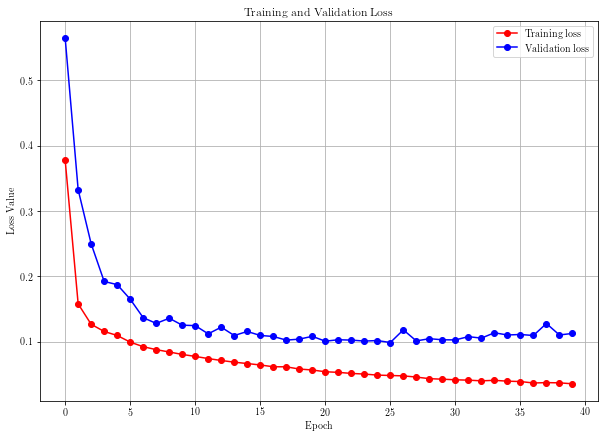

In [16]:
loss = trained_192.history['loss']
val_loss = trained_192.history['val_loss']

epochs = range(EPOCHS)

plt.figure(figsize=(10,7))
plt.plot(epochs, loss, c='red', marker='o', label='Training loss')
plt.plot(epochs, val_loss, c='b', marker='o', label='Validation loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid()

plt.show()

Save the model.

In [17]:
# serialize model to JSON
model_json = model_192.to_json()
with open('Models/model_192.json', 'w') as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_192.save_weights('Models/model_192.h5')
print('Saved model to disk')

# json_file = open('model_224.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# modelo_224_4k = model_from_json(loaded_model_json)
# # load weights into new model
# modelo_224_4k.load_weights("model_224.h5")
# print("Loaded model from disk")

Saved model to disk


## GIF

Create a simple animation of the training process.

In [20]:
import imageio

images = []
filenames = ['Gif/192/{}.jpg'.format(i) for i in range(EPOCHS)]

for filename in filenames:
    images.append(imageio.imread(filename))
    
imageio.mimsave('Gif/training_192.gif', images, duration=0.4, loop=0, fps=30)